In [145]:
import traja
import pandas as pd
import numpy as np
from pathlib import Path
import os
import glob
os.getcwd()
df=pd.read_csv('df_model.csv')

In [234]:
#data preprocessing
df1=pd.DataFrame()
df1=df.replace([np.inf, -np.inf], np.nan).dropna()
df2=df1.loc[:, ~df1.columns.isin(['validation','user_id','system'])]

### Heatmap Analysis

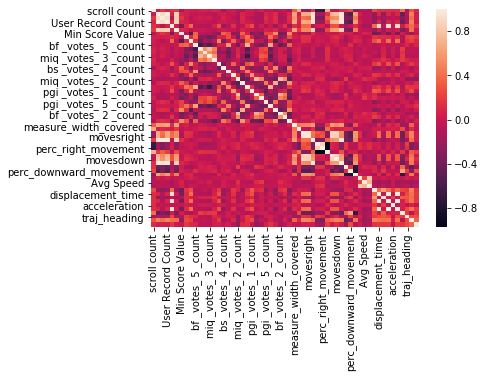

In [149]:
import seaborn as sns
corrmat = df1.corr()
sns.heatmap(corrmat)

### PCA

In [150]:
#normalize the data
from sklearn import preprocessing

X = preprocessing.normalize(df1)

In [151]:
#perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

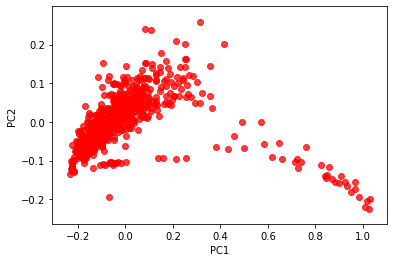

In [152]:
#plot PC1 and PC2
plt.scatter(X_pca.T[0], X_pca.T[1], alpha=0.75, c='red')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [239]:
principalDf = pd.DataFrame(data = X_pca
             , columns = ['principal component 1', 'principal component 2'])

In [241]:
finalDf = pd.concat([principalDf, df1[['validation','user_id']]], axis = 1)

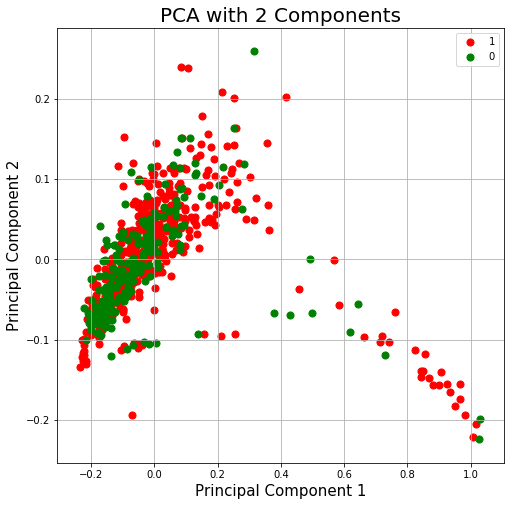

In [155]:
#Plot PCA result with validation added
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA with 2 Components', fontsize = 20)
validations = [1, 0]
colors = ['r', 'g']
for validation, color in zip(validations,colors):
    indicesToKeep = finalDf['validation'] == validation
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(validations)
ax.grid()

In [156]:
#calculate pca explained variance
pca.explained_variance_ratio_

array([0.85269749, 0.09177222])

# Clustering

### K-Means

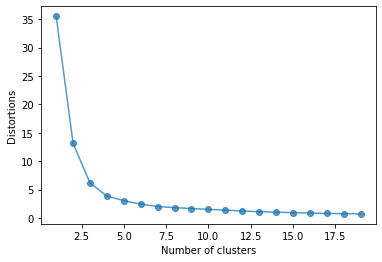

In [176]:
distortions = [] # sum of squared error within the each cluster
for i in range(1, 20):
    km = KMeans(n_clusters=i,
               init='k-means++',
               n_init=10,
               max_iter=300,
               random_state=0)
    km.fit(X_pca)
    distortions.append(km.inertia_)

plt.plot(range(1,20), distortions, marker='o', alpha=0.75)
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.show()

In [177]:
#K- means
from sklearn.cluster import KMeans
#Kmeans using pca results
km = KMeans(n_clusters=2,
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=0)

y_km = km.fit_predict(X_pca)

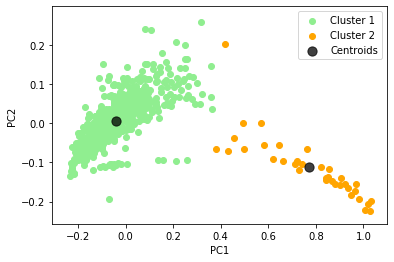

In [178]:
#plot K-means result
plt.scatter(X_pca[y_km==0, 0],
           X_pca[y_km==0, 1],
           c='lightgreen',
           label='Cluster 1')
plt.scatter(X_pca[y_km==1, 0],
           X_pca[y_km==1, 1],
           c='orange',
           label='Cluster 2')
plt.scatter(km.cluster_centers_[:,0],
           km.cluster_centers_[:,1],
           s=85,
           alpha=0.75,
           marker='o',
           c='black',
           label='Centroids')

plt.legend(loc='best')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [267]:
#get the users per each cluster

km_clust=pd.DataFrame(km.labels_, columns=['km_label']) 

#0 is cluster 1 
#1 is cluster 2

In [270]:
km_clust['user_id'] =df1['user_id'].values
km_clust['validation']=df1['validation'].values
km_clust['km_label'].value_counts()

0    669
1     35
Name: km_label, dtype: int64

In [278]:
#km_clust.to_csv('km_clusters.csv')

### K-NN

In [179]:
#KNN for each PCA Data Point
from sklearn.neighbors import NearestNeighbors as knn

knn_class= knn(n_neighbors=10)
y_knn = knn_class.fit(X_pca)

In [180]:
distances, indices = y_knn.kneighbors(X_pca)

In [181]:
distances

array([[0.        , 0.0073824 , 0.0074062 , ..., 0.01498258, 0.01640468,
        0.01653314],
       [0.        , 0.00608045, 0.00618286, ..., 0.01069268, 0.0109155 ,
        0.01107058],
       [0.        , 0.00173642, 0.00417745, ..., 0.01147998, 0.01157646,
        0.01288082],
       ...,
       [0.        , 0.00070717, 0.00437511, ..., 0.01091287, 0.01220759,
        0.01279692],
       [0.        , 0.0041606 , 0.00632055, ..., 0.01365706, 0.01419618,
        0.01436119],
       [0.        , 0.00227242, 0.00473302, ..., 0.00867781, 0.00971637,
        0.0108513 ]])

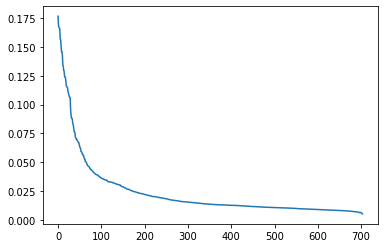

In [183]:
#knn distance plot to determine DBSCAN eps
distanceDec = sorted(distances[:,10-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

### DB-SCAN

In [184]:
#DBSCAN
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=0.04,
             min_samples=5)

y_dbs = dbs.fit_predict(X_pca)

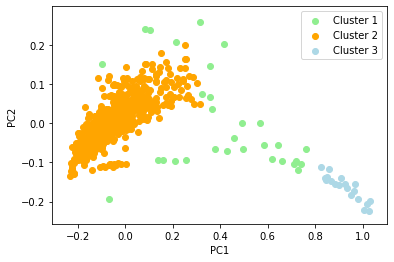

In [190]:
#plot DB-SCAN results
plt.scatter(X_pca[y_dbs==-1, 0],
           X_pca[y_dbs==-1, 1],
           c='lightgreen',
           label='Cluster 1')
plt.scatter(X_pca[y_dbs==0, 0],
           X_pca[y_dbs==0, 1],
           c='orange',
           label='Cluster 2')
plt.scatter(X_pca[y_dbs==1, 0],
           X_pca[y_dbs==1, 1],
           c='lightblue',
           label='Cluster 3')
plt.legend(loc='best')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [276]:
#get the users per each cluster

dbs_clust=pd.DataFrame(dbs.labels_, columns=['dbs_label']) 

#-1 is cluster 1 
#0 is cluster 2
#1 is cluster 3

In [277]:
dbs_clust['user_id'] =df1['user_id'].values
dbs_clust['validation']=df1['validation'].values
dbs_clust['dbs_label'].value_counts()

 0    655
-1     30
 1     19
Name: dbs_label, dtype: int64

In [279]:
#dbs_clust.to_csv("dbs_clusters.csv")